In [1]:
%cd /content
!pip install carvekit_colab

from carvekit.ml.files.models_loc import download_all

download_all();

/content
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 899.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvji

In [ ]:
#@title Upload images from your computer
#@markdown Description of parameters
#@markdown - `SHOW_FULLSIZE`  - Shows image in full size (may take a long time to load)
#@markdown - `PREPROCESSING_METHOD`  - Preprocessing method
#@markdown - `SEGMENTATION_NETWORK`  - Segmentation network. Use `u2net` for hairs-like objects and `tracer_b7` for objects
#@markdown - `POSTPROCESSING_METHOD`  - Postprocessing method
#@markdown - `SEGMENTATION_MASK_SIZE` - Segmentation mask size. Use 640 for Tracer B7 and 320 for U2Net
#@markdown - `TRIMAP_DILATION`  - The size of the offset radius from the object mask in pixels when forming an unknown area
#@markdown - `TRIMAP_EROSION`  - The number of iterations of erosion that the object's mask will be subjected to before forming an unknown area
#@markdown > Look README.md and code for more details on networks and methods


import torch
from IPython import display
from google.colab import files
from carvekit.web.schemas.config import MLConfig
from carvekit.web.utils.init_utils import init_interface

SHOW_FULLSIZE = False #@param {type:"boolean"}
PREPROCESSING_METHOD = "none" #@param ["stub", "none"]
SEGMENTATION_NETWORK = "tracer_b7" #@param ["u2net", "deeplabv3", "basnet", "tracer_b7"]
POSTPROCESSING_METHOD = "fba" #@param ["fba", "none"]
SEGMENTATION_MASK_SIZE = 640 #@param ["640", "320"] {type:"raw", allow-input: true}
TRIMAP_DILATION = 30 #@param {type:"integer"}
TRIMAP_EROSION = 5 #@param {type:"integer"}
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'


config = MLConfig(segmentation_network=SEGMENTATION_NETWORK,
                  preprocessing_method=PREPROCESSING_METHOD,
                  postprocessing_method=POSTPROCESSING_METHOD,
                  seg_mask_size=SEGMENTATION_MASK_SIZE,
                  trimap_dilation=TRIMAP_DILATION,
                  trimap_erosion=TRIMAP_EROSION,
                  device=DEVICE)


interface = init_interface(config)




uploaded = files.upload().keys()
display.clear_output()
images = interface(uploaded)
for im in enumerate(images):
  if not SHOW_FULLSIZE:
    im[1].thumbnail((768, 768), resample=3)
  display.display(im[1])



Processing image with CarveKit...
Saved as composited_result.png


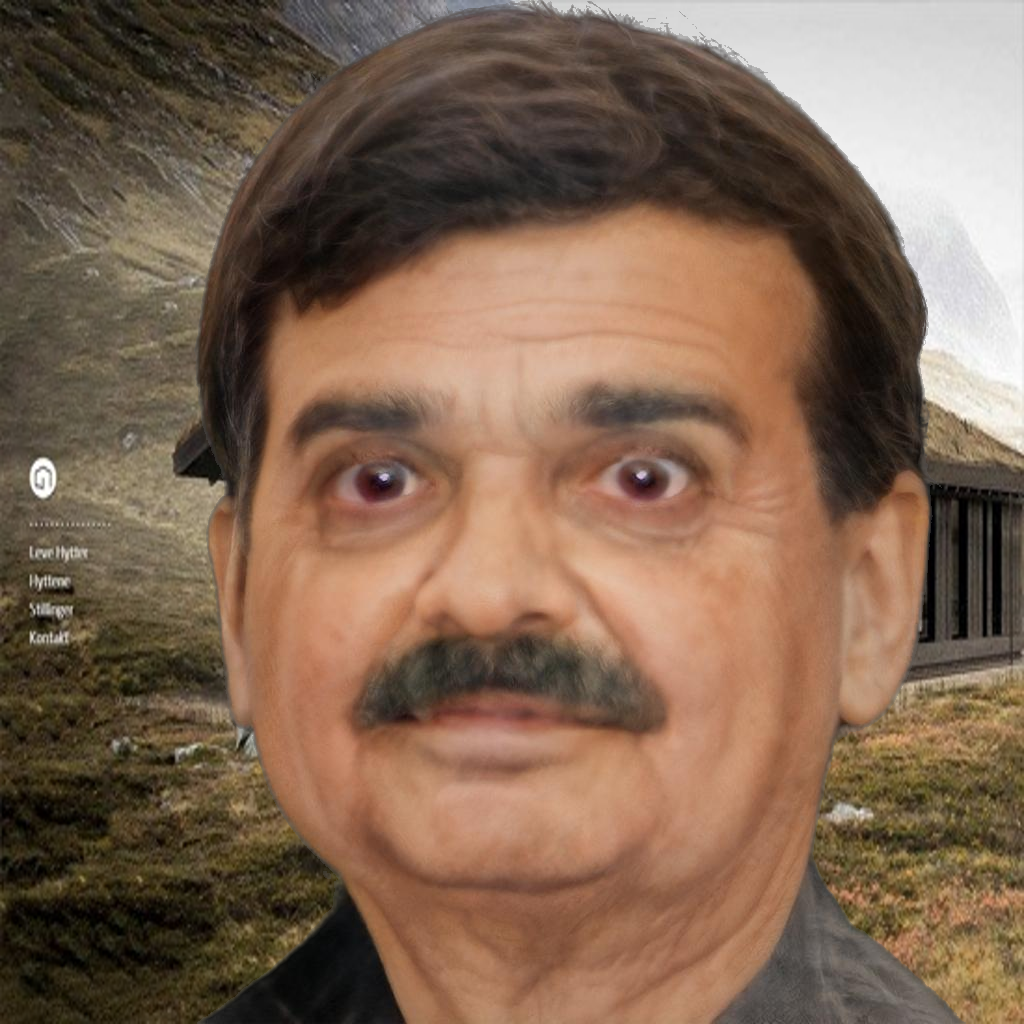

In [3]:
import torch
import requests
from PIL import Image
from io import BytesIO
from carvekit.web.schemas.config import MLConfig
from carvekit.web.utils.init_utils import init_interface

def replace_background(foreground_url, background_url, output_path="composited_result.png", device=None):
    """
    Replace the background of an image using CarveKit.

    Args:
        foreground_url (str): URL of the image with background to remove
        background_url (str): URL of the custom background image
        output_path (str): Path to save the final composited image
        device (str): Device to use ('cuda' or 'cpu'). Auto-detects if None.

    Returns:
        PIL.Image: The final composited image
    """

    # Auto-detect device if not specified
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # CarveKit Configuration
    config = MLConfig(
        segmentation_network="tracer_b7",           # Best for object cutouts
        preprocessing_method="none",
        postprocessing_method="fba",                # Use matting for soft edges
        seg_mask_size=640,
        trimap_dilation=30,
        trimap_erosion=5,
        device=device
    )

    # Initialize CarveKit Interface
    interface = init_interface(config)

    try:
        # Download foreground image
        print("Downloading foreground image...")
        foreground_response = requests.get(foreground_url)
        foreground_response.raise_for_status()
        foreground_img = Image.open(BytesIO(foreground_response.content))

        # Save temporarily for CarveKit processing
        temp_foreground_path = "temp_foreground.jpg"
        foreground_img.save(temp_foreground_path)

        # Download background image
        print("Downloading background image...")
        background_response = requests.get(background_url)
        background_response.raise_for_status()
        background = Image.open(BytesIO(background_response.content)).convert("RGBA")

        # Remove background using CarveKit
        print("Processing image with CarveKit...")
        result_images = interface([temp_foreground_path])
        foreground = result_images[0].convert("RGBA")

        # Resize background to match the foreground
        background = background.resize(foreground.size)

        # Composite: paste the foreground (with alpha mask) over the background
        final_image = Image.alpha_composite(background, foreground)

        # Save final image
        final_image.save(output_path)
        print(f"Saved as {output_path}")

        # Clean up temporary file
        import os
        os.remove(temp_foreground_path)

        return final_image

    except requests.exceptions.RequestException as e:
        print(f"Error downloading image: {e}")
        return None
    except Exception as e:
        print(f"Error processing image: {e}")
        return None

# Example usage:
if __name__ == "__main__":
    # Example URLs (replace with your actual image URLs)
    foreground_url = "https://speak-portrait.s3.ap-south-1.amazonaws.com/6cnNIgkqchZxert3i2U0eUhcmoH2/b7a1c605-4d1a-4651-b759-c83dbfd28288/image/transformed-age-80-1754151220036.jpg"
    background_url = "https://www.webfx.com/wp-content/uploads/2021/10/0451-08-website-background-image-levehytter.jpg"

    # Process the images
    result = replace_background(foreground_url, background_url)

    if result:
        # Display the result (if in Jupyter/Colab)
        try:
            from IPython import display
            display.display(result)
        except ImportError:
            print("Result saved successfully!")
    else:
        print("Failed to process images.")

In [4]:
!pip install cloudinary pyngrok

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 5.6 MB/s eta 0:00:00


In [6]:
import asyncio
import json
import os
import tempfile
import uuid
from typing import Optional
import requests
import torch
import cloudinary
import cloudinary.uploader
from fastapi import FastAPI, WebSocket, WebSocketDisconnect, HTTPException
from fastapi.middleware.cors import CORSMiddleware
from PIL import Image
from io import BytesIO
from carvekit.web.schemas.config import MLConfig
from carvekit.web.utils.init_utils import init_interface
import uvicorn
from pyngrok import ngrok
import threading
import nest_asyncio

nest_asyncio.apply()

# Configuration
CLOUDINARY_CLOUD_NAME = os.getenv("CLOUDINARY_CLOUD_NAME", "da52uzpu4")
CLOUDINARY_API_KEY = os.getenv("CLOUDINARY_API_KEY", "545616752118824")
CLOUDINARY_API_SECRET = os.getenv("CLOUDINARY_API_SECRET", "fCn5NrmoD5-WpFVHa00q53Vsw7s")
NGROK_AUTH_TOKEN = os.getenv("NGROK_AUTH_TOKEN", "2z6GLE33Qw99xRpyn6hoATNvWSJ_6GUaHDoUQWUbdnqDgcW7D")

# Configure Cloudinary
cloudinary.config(
    cloud_name=CLOUDINARY_CLOUD_NAME,
    api_key=CLOUDINARY_API_KEY,
    api_secret=CLOUDINARY_API_SECRET
)

# FastAPI app
app = FastAPI(title="CarveKit Background Replacement Service")

# Add CORS middleware
app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"],
    allow_credentials=True,
    allow_methods=["*"],
    allow_headers=["*"],
)

# Initialize CarveKit
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
config = MLConfig(
    segmentation_network="tracer_b7",
    preprocessing_method="none",
    postprocessing_method="fba",
    seg_mask_size=640,
    trimap_dilation=30,
    trimap_erosion=5,
    device=DEVICE
)

# Global interface (initialize once)
carvekit_interface = None

def initialize_carvekit():
    """Initialize CarveKit interface"""
    global carvekit_interface
    if carvekit_interface is None:
        carvekit_interface = init_interface(config)
    return carvekit_interface

class ConnectionManager:
    def __init__(self):
        self.active_connections: list[WebSocket] = []

    async def connect(self, websocket: WebSocket):
        await websocket.accept()
        self.active_connections.append(websocket)

    def disconnect(self, websocket: WebSocket):
        self.active_connections.remove(websocket)

    async def send_personal_message(self, message: dict, websocket: WebSocket):
        await websocket.send_text(json.dumps(message))

manager = ConnectionManager()

async def download_image(url: str, temp_dir: str) -> str:
    """Download image from URL and save to temporary file"""
    try:
        response = requests.get(url, timeout=30)
        response.raise_for_status()

        # Generate unique filename
        filename = f"{uuid.uuid4()}.jpg"
        filepath = os.path.join(temp_dir, filename)

        # Save image
        img = Image.open(BytesIO(response.content))
        img.save(filepath, "JPEG")

        return filepath
    except Exception as e:
        raise Exception(f"Failed to download image: {str(e)}")

async def upload_to_cloudinary(image_path: str) -> str:
    """Upload image to Cloudinary and return URL"""
    try:
        result = cloudinary.uploader.upload(
            image_path,
            folder="carvekit_results",
            public_id=f"result_{uuid.uuid4()}",
            overwrite=True,
            resource_type="image"
        )
        return result['secure_url']
    except Exception as e:
        raise Exception(f"Failed to upload to Cloudinary: {str(e)}")

async def process_background_replacement(foreground_url: str, background_url: str) -> str:
    """Process background replacement and return Cloudinary URL"""

    # Create temporary directory
    with tempfile.TemporaryDirectory() as temp_dir:
        try:
            # Download images
            foreground_path = await download_image(foreground_url, temp_dir)
            background_response = requests.get(background_url, timeout=30)
            background_response.raise_for_status()
            background = Image.open(BytesIO(background_response.content)).convert("RGBA")

            # Initialize CarveKit interface
            interface = initialize_carvekit()

            # Remove background
            result_images = interface([foreground_path])
            foreground = result_images[0].convert("RGBA")

            # Resize background to match foreground
            background = background.resize(foreground.size)

            # Composite images
            final_image = Image.alpha_composite(background, foreground)

            # Save result
            result_path = os.path.join(temp_dir, f"result_{uuid.uuid4()}.png")
            final_image.save(result_path, "PNG")

            # Upload to Cloudinary
            cloudinary_url = await upload_to_cloudinary(result_path)

            return cloudinary_url

        except Exception as e:
            raise Exception(f"Processing failed: {str(e)}")

@app.websocket("/ws")
async def websocket_endpoint(websocket: WebSocket):
    await manager.connect(websocket)
    try:
        while True:
            # Receive message
            data = await websocket.receive_text()
            message = json.loads(data)

            # Send acknowledgment
            await manager.send_personal_message({
                "type": "status",
                "message": "Request received, processing...",
                "status": "processing"
            }, websocket)

            try:
                # Extract URLs
                foreground_url = message.get("foreground_url")
                background_url = message.get("background_url")

                if not foreground_url or not background_url:
                    await manager.send_personal_message({
                        "type": "error",
                        "message": "Both foreground_url and background_url are required",
                        "status": "error"
                    }, websocket)
                    continue

                # Process images
                await manager.send_personal_message({
                    "type": "status",
                    "message": "Downloading images...",
                    "status": "downloading"
                }, websocket)

                await manager.send_personal_message({
                    "type": "status",
                    "message": "Removing background...",
                    "status": "processing"
                }, websocket)

                # Process background replacement
                result_url = await process_background_replacement(foreground_url, background_url)

                await manager.send_personal_message({
                    "type": "status",
                    "message": "Uploading result...",
                    "status": "uploading"
                }, websocket)

                # Send success response
                await manager.send_personal_message({
                    "type": "result",
                    "message": "Background replacement completed successfully!",
                    "status": "completed",
                    "result_url": result_url,
                    "foreground_url": foreground_url,
                    "background_url": background_url
                }, websocket)

            except Exception as e:
                await manager.send_personal_message({
                    "type": "error",
                    "message": f"Error: {str(e)}",
                    "status": "error"
                }, websocket)

    except WebSocketDisconnect:
        manager.disconnect(websocket)

@app.get("/")
async def root():
    return {"message": "CarveKit Background Replacement Service", "status": "running"}

@app.get("/health")
async def health_check():
    return {
        "status": "healthy",
        "device": DEVICE,
        "carvekit_initialized": carvekit_interface is not None
    }

def start_ngrok():
    """Start ngrok tunnel"""
    try:
        # Set auth token if provided
        if NGROK_AUTH_TOKEN and NGROK_AUTH_TOKEN != "your_ngrok_token":
            ngrok.set_auth_token(NGROK_AUTH_TOKEN)

        # Start tunnel
        public_url_object = ngrok.connect(8000)
        public_url = public_url_object.public_url
        print(f"\n🌐 Public URL: {public_url}")
        print(f"🔌 WebSocket URL: {public_url.replace('http', 'ws')}/ws")
        print(f"📊 Health Check: {public_url}/health")

        return public_url
    except Exception as e:
        print(f"❌ Failed to start ngrok: {e}")
        print("💡 Make sure to set NGROK_AUTH_TOKEN environment variable")
        return None

if __name__ == "__main__":
    print("🚀 Starting CarveKit Background Replacement Service...")
    print(f"🔧 Device: {DEVICE}")

    # Start ngrok in separate thread
    ngrok_thread = threading.Thread(target=start_ngrok)
    ngrok_thread.daemon = True
    ngrok_thread.start()

    # Initialize CarveKit
    print("🤖 Initializing CarveKit...")
    initialize_carvekit()
    print("✅ CarveKit initialized!")

    # Start FastAPI server
    uvicorn.run(
        app,
        host="0.0.0.0",
        port=8000,
        log_level="info"
    )

🚀 Starting CarveKit Background Replacement Service...
🔧 Device: cuda
🤖 Initializing CarveKit...

🌐 Public URL: https://859e9537b404.ngrok-free.app
🔌 WebSocket URL: wss://859e9537b404.ngrok-free.app/ws
📊 Health Check: https://859e9537b404.ngrok-free.app/health
✅ CarveKit initialized!


INFO:     Started server process [637]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)
INFO:     103.159.214.186:0 - "WebSocket /ws" [accepted]
INFO:     connection open
INFO:     connection closed
INFO:     103.159.214.186:0 - "WebSocket /ws" [accepted]
INFO:     connection open
INFO:     connection closed
INFO:     103.159.214.186:0 - "WebSocket /ws" [accepted]
INFO:     connection open
INFO:     connection closed
INFO:     Shutting down
INFO:     Finished server process [637]
